<a href="https://colab.research.google.com/github/ahmad-PH/nag-notebooks/blob/master/NAG_tripletLossExperiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [205]:
import os; import subprocess

def detect_env():
    return 'colab' if 'content' in os.listdir('/') else 'IBM'
  
def run_shell_command(cmd):
  p = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE)
  print(str(p.communicate()[0], 'utf-8'))
  
if detect_env() == 'colab': root_folder = '/content'
elif detect_env() == 'IBM' : root_folder = '/root/Derakhshani/adversarial'
python_files_path = root_folder + '/nag-public'

if os.path.isdir(python_files_path):
  initial_dir = os.getcwd()
  os.chdir(python_files_path)
  run_shell_command('git pull')
  os.chdir(initial_dir)
else:
  os.chdir('/root/Derakhshani/adversarial')
  run_shell_command('git clone https://github.com/ahmad-PH/nag-public.git')

Already up-to-date.



In [206]:
import sys
sys.path.append(python_files_path + '/NAG-11May-beforeDenoiser')

from nag_util import *
import nag_util
from environment import *
from visualization import *

env = create_env()
env.setup(cuda_index = 0)

In [207]:
from fastai.vision import *
from fastai.imports import *
from fastai.callbacks import *
from fastai.utils.mem import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import numpy as np
import sys; import os; import shutil

In [208]:
class GeneralRelu(nn.Module):
  def __init__(self, leak=None, sub=None, maxv=None):
    super().__init__()
    self.leak,self.sub,self.maxv = leak,sub,maxv

  def forward(self, x): 
    x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
    if self.sub is not None: x.sub_(self.sub)
    if self.maxv is not None: x.clamp_max_(self.maxv)
    return x
  
class deconv_layer(nn.Module):
    def __init__(self, in_ch, out_ch, k_size = (4,4), s = (2,2), pad = (1,1), b = True, activation = True):
        super(deconv_layer, self).__init__()

        self.CT2d = nn.ConvTranspose2d(in_channels = in_ch,
                                  out_channels = out_ch,
                                  kernel_size = k_size,
                                  stride = s, 
                                  padding = pad,
                                  bias = b)
        self.BN2d = nn.BatchNorm2d(out_ch)
        
        self.activation = activation
        if self.activation:
            self.relu = GeneralRelu(0, 0.2, 5)
        
        self.weight_init()
    
    def forward(self, input):
        if self.activation:
            return self.relu(self.BN2d(self.CT2d(input)))
        else:
            return self.BN2d(self.CT2d(input))

    def weight_init(self):
        self.CT2d.weight.data.normal_(mean = 0, std = 0.02)
        self.CT2d.bias.data.fill_(0)


In [209]:
# class Gen(nn.Module):
#   def __init__(self, z_dim, gf_dim=64, y_dim = None, df_dim = 64, image_shape = [3,128,128]):
#     super(Gen, self).__init__()

#     self.bs = None
#     self.z_dim = z_dim
#     self.gf_dim = gf_dim
#     self.y_dim = y_dim
#     self.df_dim = df_dim
#     self.image_shape = image_shape

#     self.z_ = nn.Linear(self.z_dim, self.gf_dim * 7 * 4 * 4, bias=True)
#     self.z_.bias.data.fill_(0)
#     self.BN_ = nn.BatchNorm2d(self.gf_dim * 7)

#     self.half = max(self.gf_dim // 2, 1) 
#     self.quarter = max(self.gf_dim // 4, 1)
#     self.eighth = max(self.gf_dim // 8, 1)
#     # sixteenth = max(self.gf_dim // 16, 1)
    
#     self.CT2d_1 = deconv_layer(self.gf_dim * 8, self.gf_dim * 4, k_size = (5,5), pad = (2,2))
#     self.CT2d_2 = deconv_layer(self.gf_dim * 5, self.gf_dim * 2)    
#     self.CT2d_3 = deconv_layer(self.gf_dim * 2 + self.half, self.gf_dim * 1)
#     self.CT2d_4 = deconv_layer(self.gf_dim * 1 + self.quarter, self.gf_dim * 1)
#     self.CT2d_5 = deconv_layer(self.gf_dim * 1 + self.eighth, self.gf_dim * 1)
#     self.CT2d_6 = deconv_layer(self.gf_dim * 1 + self.eighth, self.gf_dim * 1)
#     self.CT2d_7 = deconv_layer(self.gf_dim * 1 + self.eighth, 3, k_size = (5,5), s = (1,1), pad = (2,2), activation = False)

#   def randomized_deconv_layer(self, h_input, z_size_0, z_size_1, deconv_layer, expected_output_size):
#     h_input_z = self.make_z([self.bs, z_size_0, z_size_1, z_size_1])
#     h_input = torch.cat([h_input, h_input_z], dim = 1)
#     output = deconv_layer(h_input)
#     assert output.shape[2:] == (expected_output_size, expected_output_size), \
#             "Unexpected output shape at randomized_deconv_layer. expected" + \
#             "({0},{0}), got {1}".format(expected_output_size, output.shape[2:])
#     return output
  
#   def forward_z(self, z):
#     self.bs = z.shape[0]
    
#     h0 = F.relu(self.BN_(self.z_(z).contiguous().view(self.bs, -1, 4, 4)))
#     assert h0.shape[2:] == (4, 4), "Unexpected shape, it shoud be (4,4)"

#     h1 = self.randomized_deconv_layer(h0, self.gf_dim, 4, self.CT2d_1, 7)
#     h2 = self.randomized_deconv_layer(h1, self.gf_dim, 7, self.CT2d_2, 14)
#     h3 = self.randomized_deconv_layer(h2, self.half, 14, self.CT2d_3, 28)
#     h4 = self.randomized_deconv_layer(h3, self.quarter, 28, self.CT2d_4, 56)
#     h5 = self.randomized_deconv_layer(h4, self.eighth, 56, self.CT2d_5, 112)
#     h6 = self.randomized_deconv_layer(h5, self.eighth, 112, self.CT2d_6, 224)
#     h7 = self.randomized_deconv_layer(h6, self.eighth, 224, self.CT2d_7, 224)

#     ksi = 10.0
#     output_coeff = ksi / (255.0 * np.mean(imagenet_stats[1])) 
#     # this coeff scales the output to be appropriate for images that are 
#     # normalized using imagenet_stats (and are hence in the approximate [-2.5, 2.5]
#     # interval)
#     return output_coeff * torch.tanh(h7)
  
# #   # blind-selection
#   def forward(self, inputs):
#     self.bs = inputs.shape[0]

#     benign_preds_onehot = arch(inputs)
#     benign_preds = torch.argmax(benign_preds_onehot, dim = 1)
    
#     z = torch.zeros([self.bs, 1000]).cuda()
#     for i in range(self.bs):
#       random_label = self.randint(0,1000, exclude = benign_preds[i].item())
#       z[i][random_label] = 1.
    
#     z_out = self.forward_z(z)
    
#     return z_out, None, None, inputs, benign_preds_onehot, z

# #   #second-best selection: made validation so much worse
# #   def forward(self, inputs):
# #     self.bs = inputs.shape[0]

# #     benign_preds_onehot = arch(inputs)
# #     target_preds = torch.topk(benign_preds_onehot, 2, dim = 1).indices[:, 1:]
    
# #     z = torch.zeros([self.bs, 1000]).cuda()
# #     for i in range(self.bs):
# #       z[i][target_preds[i]] = 1.
    
# #     z_out = self.forward_z(z)
    
# #     return z_out, None, None, inputs, benign_preds_onehot, z
  
# #    def forward(self, inputs):
# #     self.bs = inputs.shape[0]

# #     benign_preds_onehot = arch(inputs)
# #     benign_preds = torch.argmax(benign_preds_onehot, dim = 1)
    
# #     z = torch.zeros([self.bs, 1000]).cuda()
# #     random_label = self.randint(0,1000, exclude = benign_preds.tolist())
# #     for i in range(self.bs):
# #       z[i][random_label] = 1.
    
# #     z_out = self.forward_z(z)
    
# #     return z_out, None, None, inputs, benign_preds_onehot, z
  
#   @staticmethod
#   def randint(low, high, exclude):
#     temp = np.random.randint(low, high - 1)
#     if temp == exclude:
#       temp = temp + 1
#     return temp
  
#   def forward_single_z(self, z):
#     return self.forward_z(z[None]).squeeze()

#     def generate_single_noise(self):
#       z = torch.empty(self.z_dim).uniform_(-1,1).cuda()
#       return self.forward_single_z(z)    
  
#   def make_triplet_samples(self, z, margin, r2, r3):
#     positive_sample = z + self.random_vector_volume(z.shape, 0, margin).cuda() 
#     negative_sample = z + self.random_vector_volume(z.shape, r2, r3).cuda()
#     return positive_sample, negative_sample

#   def random_vector_surface(self, shape, r = 1.):
#     mat = torch.randn(size=shape).cuda()
#     norm = torch.norm(mat, p=2, dim=1, keepdim = True).cuda()
#     return (mat/norm) * r

  
#   def random_vector_volume(self, shape, inner_r, outer_r):
#     fraction = torch.empty(shape[0]).uniform_(inner_r, outer_r).cuda()
#     fraction = ((fraction / outer_r) ** (1 / shape[1])) * outer_r # volume-normalize the fraction
#     fraction.unsqueeze_(-1)
#     return self.random_vector_surface(shape, 1) * fraction

#   def make_z(self, in_shape):
#     return torch.empty(in_shape).cuda().uniform_(-1,1)


In [210]:
# non-targeted Gen
class Gen(nn.Module):
  def __init__(self, z_dim, gf_dim=64, y_dim = None, df_dim = 64, image_shape = [3,128,128]):
    super(Gen, self).__init__()

    self.bs = None
    self.z_dim = z_dim
    self.gf_dim = gf_dim
    self.y_dim = y_dim
    self.df_dim = df_dim
    self.image_shape = image_shape

    self.z_ = nn.Linear(self.z_dim, self.gf_dim * 7 * 4 * 4, bias=True)
    self.z_.bias.data.fill_(0)
    self.BN_ = nn.BatchNorm2d(self.gf_dim * 7)

    self.half = max(self.gf_dim // 2, 1) 
    self.quarter = max(self.gf_dim // 4, 1)
    self.eighth = max(self.gf_dim // 8, 1)
    # sixteenth = max(self.gf_dim // 16, 1)

    self.CT2d_1 = deconv_layer(self.gf_dim * 8, self.gf_dim * 4, k_size = (5,5), pad = (2,2))
    self.CT2d_2 = deconv_layer(self.gf_dim * 5, self.gf_dim * 2)    
    self.CT2d_3 = deconv_layer(self.gf_dim * 2 + self.half, self.gf_dim * 1)
    self.CT2d_4 = deconv_layer(self.gf_dim * 1 + self.quarter, self.gf_dim * 1)
    self.CT2d_5 = deconv_layer(self.gf_dim * 1 + self.eighth, self.gf_dim * 1)
    self.CT2d_6 = deconv_layer(self.gf_dim * 1 + self.eighth, self.gf_dim * 1)
    self.CT2d_7 = deconv_layer(self.gf_dim * 1 + self.eighth, 3, k_size = (5,5), s = (1,1), pad = (2,2), activation = False)

  def randomized_deconv_layer(self, h_input, z_size_0, z_size_1, deconv_layer, expected_output_size):
    h_input_z = self.make_z([self.bs, z_size_0, z_size_1, z_size_1])
    h_input = torch.cat([h_input, h_input_z], dim = 1)
    output = deconv_layer(h_input)
    assert output.shape[2:] == (expected_output_size, expected_output_size), \
            "Unexpected output shape at randomized_deconv_layer. expected" + \
            "({0},{0}), got {1}".format(expected_output_size, output.shape[2:])
    return output
  
  def forward_z(self, z):
    self.bs = z.shape[0]
    
    h0 = F.relu(self.BN_(self.z_(z).contiguous().view(self.bs, -1, 4, 4)))
    assert h0.shape[2:] == (4, 4), "Non-expected shape, it shoud be (4,4)"

    h1 = self.randomized_deconv_layer(h0, self.gf_dim, 4, self.CT2d_1, 7)
    h2 = self.randomized_deconv_layer(h1, self.gf_dim, 7, self.CT2d_2, 14)
    h3 = self.randomized_deconv_layer(h2, self.half, 14, self.CT2d_3, 28)
    h4 = self.randomized_deconv_layer(h3, self.quarter, 28, self.CT2d_4, 56)
    h5 = self.randomized_deconv_layer(h4, self.eighth, 56, self.CT2d_5, 112)
    h6 = self.randomized_deconv_layer(h5, self.eighth, 112, self.CT2d_6, 224)
    h7 = self.randomized_deconv_layer(h6, self.eighth, 224, self.CT2d_7, 224)

    ksi = 10.0
    output_coeff = ksi / (255.0 * np.mean(imagenet_stats[1])) 
    # this coeff scales the output to be appropriate for images that are 
    # normalized using imagenet_stats (and are hence in the approximate [-2.5, 2.5]
    # interval)
    return output_coeff * torch.tanh(h7)

  def forward(self, inputs):
    self.bs = inputs.shape[0]
    z = inputs.new_empty([self.bs, self.z_dim]).uniform_(-1,1).cuda()
    p, n = self.make_triplet_samples(z, 0.1, 0.1, 2.)
    
    z_out = self.forward_z(z)
    p_out = self.forward_z(p)
    n_out = self.forward_z(n)
    
    return z_out, p_out, n_out, inputs, z
#     return z_out, None, None, inputs
  
  def forward_single_z(self, z):
    return self.forward_z(z[None]).squeeze()
  
  def generate_single_noise(self):
    z = torch.empty(self.z_dim).uniform_(-1,1).cuda()
    return self.forward_single_z(z)
           
  
  def make_triplet_samples(self, z, margin, r2, r3):
    positive_sample = z + self.random_vector_volume(z.shape, 0, margin).cuda() 
    negative_sample = z + self.random_vector_volume(z.shape, r2, r3).cuda()
    return positive_sample, negative_sample

  def random_vector_surface(self, shape, r = 1.):
    mat = torch.randn(size=shape).cuda()
    norm = torch.norm(mat, p=2, dim=1, keepdim = True).cuda()
    return (mat/norm) * r

  
  def random_vector_volume(self, shape, inner_r, outer_r):
    fraction = torch.empty(shape[0]).uniform_(inner_r, outer_r).cuda()
    fraction = ((fraction / outer_r) ** (1 / shape[1])) * outer_r # volume-normalize the fraction
    fraction.unsqueeze_(-1)
    return self.random_vector_surface(shape, 1) * fraction

  def make_z(self, in_shape):
    return torch.empty(in_shape).cuda().uniform_(-1,1)

In [211]:
def js_distance(x1, x2):
  m = 0.5 * (x1 + x2)
  return 0.5 * (F.kl_div(x1, m) + F.kl_div(x2, m))

def kl_distance(x1, x2):
  inp = torch.log(x1)
  target = x2
  return F.kl_div(inp, target, reduction='batchmean')

def distrib_distance(x1, x2):
  x1 = tensorify(x1)
  x2 = tensorify(x2)
  x1 = x1 / torch.sum(x1)
  x2 = x2 / torch.sum(x2)
  return kl_distance(x1[None], x2[None])

def distrib_distance(x1, x2):
  if not isinstance(x1, torch.Tensor): x1 = torch.tensor(x1)
  if not isinstance(x2, torch.Tensor): x2 = torch.tensor(x2)
  x1 = x1 * 100. / torch.sum(x1)
  x2 = x2 * 100. / torch.sum(x2)
  return torch.norm(x1 - x2, 2)

def distance_from_uniform(x):
  return distrib_distance(x, [1.] * len(x))

def wasserstein_distance(x1, x2):
  return torch.mean(x1 - x2)

def l1_distance(x1, x2):
  return F.l1_loss(x1, x2)

def l2_distance(x1, x2):
  return F.mse_loss(x1 * 10, x2 * 10)

def mse_loss(x1, x2):
  return F.mse_loss(x1, x2)

def cos_distance(x1, x2, dim = 1):
  return -1 * torch.mean(F.cosine_similarity(x1, x2, dim=dim))


def triplet_loss(anchor, positive, negative, distance_func, margin):
  # max distance when using l1_distance is 2
  # max distacne when using l2-distance is sqrt(2)
#   print("anchor: ", anchor.min(), anchor.max())
  ap_dist = distance_func(anchor, positive)
  an_dist = distance_func(anchor, negative)

  triplet_loss.call_count += 1
  if triplet_loss.call_count % 200 == 0 : #and anchor.shape[1] == 1000:
#     print("a: ", end=""); print_big_vector(anchor[0])
#     print("p: ", end=""); print_big_vector(positive[0])
#     print("n: ", end=""); print_big_vector(negative[0])
    print("func:{}, ap_dist: {}, an_dist: {}".format(distance_func.__name__, ap_dist, an_dist))
    
  return torch.mean(F.relu(ap_dist - an_dist + margin))

triplet_loss.call_count = 0

In [212]:
# def diversity_loss(embeddings, z_s):
#   size = z_s.shape[0]
#   result = 0
#   for i in range(size):
#     for j in range(i+1, size):
# #       a = F.cosine_similarity(embeddings[i], embeddings[j], dim = 0)
# #       b = torch.norm(z_s[i] - z_s[j], 2, dim = 0)
# #       print('embeddings: ')
# #       print_big_vector(embeddings[i])
# #       print_big_vector(embeddings[j])
# #       print(f'a: {a}, b:{b}, multiple: {a*b}')
#       result += F.cosine_similarity(embeddings[i], embeddings[j], dim = 0) * \
#                 torch.norm(z_s[i] - z_s[j], 2, dim = 0)
#   n_pairs = (size * (size - 1)) / 2
#   mean = result / n_pairs 
# #   print(f'result {result}, n_pairs {n_pairs}, mean {mean}')
#   return mean
  

# normalized with shuffling
def diversity_loss(embeddings, deranged_embeddings, z_s, deranged_z_s):
    cos_distance = 1 - F.cosine_similarity(embeddings, deranged_embeddings)
#     z_distance = torch.norm(z_s - deranged_z_s, 2, dim = 1)
    z_distance = 1 - F.cosine_similarity(z_s, deranged_z_s)
    epsilon = 1e-10
    normalized_distance = cos_distance / (z_distance + epsilon)
    theta = 10.
    loss = -1 * torch.min(normalized_distance, torch.tensor(theta).cuda())
    
    diversity_loss.count += 1
    if diversity_loss.count % 50 == 0:
      print('\ncos dist: {}\n z_dist: {}\n normalized: {}\nloss: {}\n\n'.format(
        cos_distance, z_distance, normalized_distance,loss))
    return torch.mean(loss)
  
diversity_loss.count = 0
  
# # normalized with shuffling
# def diversity_loss(embeddings, z_s):
#     deranged_embeddings, deranged_z_s = derange(embeddings, z_s)
#     cos_similarity = F.cosine_similarity(embeddings, deranged_embeddings)
#     z_distance = torch.norm(z_s - deranged_z_s, dim = 1)
#     max_possible_z_distance = 6.3246
#     return torch.mean(cos_similarity * (z_distance/max_possible_z_distance))


# def diversity_loss(input, target):
# #   return -1 * torch.mean(torch.pow(f_x_a-f_x_s,2))
#   if input.shape[0] != batch_size:
#     print("input shape: ", input.shape)
#     print("target shape: ", target.shape, "\n\n")
#   return torch.mean(F.cosine_similarity(
#     input.view([batch_size, -1]),
#     target.view([batch_size, -1]), 
#   ))

def fool_loss(input, target):
  true_class = torch.argmax(target, dim=1).view(-1,1).long().cuda()
  target_probabilities = input.gather(1, true_class)
  epsilon = 1e-10
  result =  torch.mean(-1 * torch.log(1 - target_probabilities + epsilon))
  
  fool_loss.call_count += 1
  if fool_loss.call_count % 200 == 0:
    print("target probs {}, loss: {}: ".format(target_probabilities, result))
    
  return result

fool_loss.call_count = 0

# def fool_loss(model_output, target_labels):
#   target_labels = target_labels.view(-1, 1).long().cuda()
#   target_probabilities = model_output.gather(1, target_labels)
#   epsilon = 1e-10
#   # highest possible fool_loss is - log(1e-10) == 23
#   result = torch.mean(-1 * torch.log(target_probabilities + epsilon))
  
#   global fool_loss_count
#   fool_loss_count += 1
#   if fool_loss_count % 20 == 0:
#     print("target probs {}, loss: {}: ".format(target_probabilities, result))
  
#   return result

# # targeted 
# def validation(gen_output, target):
#   perturbations, _, _, clean_images, _, _ = gen_output
#   return validation_(perturbations, clean_images)

def validation(gen_output, target):
  perturbations, _, _, clean_images, _ = gen_output
  return validation_(perturbations, clean_images)

unfooled_histogram = np.array([0.] * 1000)
valid_cnt = 0

def validation_(perturbations, clean_images):
  perturbed_images = clean_images + perturbations
  benign_preds = torch.argmax(arch(clean_images), 1)
  adversary_preds = torch.argmax(arch(perturbed_images), 1)

#   print('benign, adversary, unfooled')
#   print(benign_preds)
#   print(adversary_preds)

#   is_unfooled = (benign_preds == adversary_preds)
#   for i , unfooled in enumerate(is_unfooled):
#     if unfooled == 1:
#       unfooled_histogram[benign_preds[i]] += 1
  
#   global valid_cnt
#   valid_cnt += 1
#   if valid_cnt % 10 == 0:
#     indexed = [(i, u) for i, u in enumerate(unfooled_histogram)]
#     summarized = list(filter(lambda x: x[1] > 0.0, indexed))
#     percent = [(i, 100. * u / np.sum(unfooled_histogram)) for i, u in summarized]
#     print('\nhist: ')
#     print(sorted(summarized, key=lambda x: x[1], reverse = True))
#     print('\npercent: ')
#     print(sorted(percent, key =lambda x: x[1], reverse = True))
#     print('\n')
    
  return (benign_preds != adversary_preds).float().mean()

In [213]:
# class FeatureLoss(nn.Module):
#     def __name__(self):
#       return "feature_loss"
  
#     def __init__(self, dis, layers, layer_weights):
#         super().__init__()
        
#         # define generator here 
#         self.dis = dis
#         self.diversity_layers = layers
#         self.hooks = hook_outputs(self.diversity_layers, detach=False)
#         self.weights = layer_weights
#         self.metric_names = ["fool_loss"] #+ [f"div_loss_{i}" for i in range(len(layers))] #maybe Gram
# #         self.triplet_hooks = hook_outputs([arch.m.features[4]], detach=False)
    
#     def make_features(self, x, clone=False):
#         y = self.dis(x)
#         return y, [(o.clone() if clone else o) for o in self.hooks.stored]
  
#     def forward(self, inp, target):
#       sigma_B, _, _, X_B, B_Y, z = inp

#       X_A = X_B + sigma_B
# #       X_S = self.add_perturbation_shuffled(X_B, sigma_B) # Shuffled Addversarial Examples

#       A_Y, A_feat = self.make_features(X_A)
# #       _, S_feat = self.make_features(X_S)

#       chosen_labels = z.argmax(dim=1)
#       fooling_loss =  fool_loss(A_Y, chosen_labels)

# #       raw_diversity_losses = [diversity_loss(a_f, s_f) for a_f, s_f in zip(A_feat, S_feat)]
# #       weighted_diversity_losses = [diversity_loss(a_f, s_f) * weight for a_f, s_f, weight in zip(A_feat, S_feat, self.weights)]

# #       self.losses = [fooling_loss] + weighted_diversity_losses
# #       self.metrics = dict(zip(self.metric_names, [fooling_loss] + raw_diversity_losses))

#       self.losses = [fooling_loss]
#       self.metrics = dict(zip(self.metric_names, [fooling_loss]))

#       return sum(self.losses)
  
#     def add_perturbation_shuffled(self, inp, perturbation):
# #       j = torch.randperm(inp.shape[0])
#         j = derangement(inp.shape[0])
#         return inp.add(perturbation[j])

In [214]:
def derange(*args):
  if len(args) == 0: raise ValueError('shuffle function needs atleast one argument')
  deranged_indexes = derangement(args[0].shape[0])
  if not all([args[0].shape[0] == arg.shape[0] for arg in args]): 
    raise ValueError('inputs to shuffle must all have the same 0th dimension')
  return [arg[deranged_indexes] for arg in args]

In [215]:
#non-targeted FeatureLoss
class FeatureLoss(nn.Module):
    def __name__(self):
      return "feature_loss"
  
    def __init__(self, dis, layers, layer_weights):
        super().__init__()
        
        self.dis = dis
        self.diversity_layers = layers
        self.hooks = hook_outputs(self.diversity_layers, detach=False)
        self.weights = layer_weights
        
#         self.metric_names = ["fool_loss"] + [f"div_loss_{i}" for i in range(len(layers))] + ['triplet_loss']# Maybe Gram
#         self.metric_names = ["div_loss"] + ['triplet_loss']# Maybe Gram
        self.metric_names = ["fool_loss"] + ['div_loss']# Maybe Gram
#         self.metric_names = ["div_loss"]
        self.triplet_weight = 1.
        self.div_weight = 1.
        self.fooling_weight = 1.
    
    def make_features(self, x, clone=False):
        y = self.dis(x)
        return y, [(o.clone() if clone else o) for o in self.hooks.stored]
  
    # contrastive loss
    def forward(self, inp, target):
        sigma_B, sigma_pos, sigma_neg, X_B, z_B = inp

        deranged_perturbations, deranged_z_s = derange(sigma_B, z_B)
        
        X_A = X_B + sigma_B
        X_S = X_B + deranged_perturbations
        X_A_pos = X_B + sigma_pos
        X_A_neg = X_B + sigma_neg
        
        B_Y, _ = self.make_features(X_B)
        A_Y, A_feat = self.make_features(X_A)
        _, S_feat = self.make_features(X_S)
        pos_softmax, _ = self.make_features(X_A_pos)
        neg_softmax, _ = self.make_features(X_A_neg)
        
        raw_fooling_loss =  fool_loss(A_Y, B_Y)
        weighted_fooling_loss = self.fooling_weight * raw_fooling_loss
      
        raw_diversity_loss = diversity_loss(A_feat[0], S_feat[0], z_B, deranged_z_s)
#         raw_diversity_loss = diversity_loss(A_feat[0], S_feat[0])
        weighted_diversity_loss = raw_diversity_loss * self.div_weight
        
#         raw_triplet_loss = triplet_loss(A_Y, pos_softmax, neg_softmax, cos_distance, 1.4)
#         weighted_triplet_loss = raw_triplet_loss * self.triplet_weight
    
        self.losses = [weighted_diversity_loss]
        raw_losses = [raw_diversity_loss]
  
#         self.losses = weighted_diversity_losses + [weighted_triplet_loss]
#         raw_losses = raw_diversity_losses + [raw_triplet_loss]
        
        self.losses = [weighted_fooling_loss] + [weighted_diversity_loss] #+ [weighted_triplet_loss]
        raw_losses = [raw_fooling_loss] + [raw_diversity_loss] #+ [raw_triplet_loss]
        
#         self.losses = [fooling_loss] + [weighted_triplet_loss]
#         self.metrics = dict(zip(self.metric_names, [fooling_loss] + [raw_triplet_loss]))
      
        if len(self.metric_names) != len(raw_losses):
          raise Exception("length of metric names unequals length of losses")
        
        self.metrics = dict(zip(self.metric_names, raw_losses))
        return sum(self.losses)
  
  
  
# #     triplet loss
#     def forward(self, inp, target):
#         sigma_B, sigma_pos, sigma_neg, X_B, _ = inp

#         X_A = self.add_perturbation(X_B, sigma_B) 
#         X_A_pos = self.add_perturbation(X_B, sigma_pos)
#         X_A_neg = self.add_perturbation(X_B, sigma_neg) 
#         X_S = self.add_perturbation_shuffled(X_B, sigma_B) # Shuffled Addversarial Examples
        
# #         B_Y, _ = self.make_features(X_B)
#         A_Y, A_feat = self.make_features(X_A)
# #         _, S_feat = self.make_features(X_S)
#         pos_softmax, _ = self.make_features(X_A_pos)
#         neg_softmax, _ = self.make_features(X_A_neg)
        
# #         raw_fooling_loss =  fool_loss(A_Y, B_Y)
# #         weighted_fooling_loss = self.fooling_weight * raw_fooling_loss
      
#         raw_diversity_losses = [diversity_loss(a_f, s_f, sigma_B, ) for a_f, s_f in zip(A_feat, S_feat)]
#         weighted_diversity_losses = [diversity_loss(a_f, s_f) * weight * self.div_weight for a_f, s_f, weight in zip(A_feat, S_feat, self.weights)]
#         raw_triplet_loss = triplet_loss(A_Y, pos_softmax, neg_softmax, cos_distance, 1.4)
#         weighted_triplet_loss = raw_triplet_loss * self.triplet_weight
    
#         self.losses = weighted_diversity_losses + [weighted_triplet_loss]
#         raw_losses = raw_diversity_losses + [raw_triplet_loss]
        
# #         self.losses = [weighted_fooling_loss] + weighted_diversity_losses + [weighted_triplet_loss]
# #         raw_losses = [raw_fooling_loss] + raw_diversity_losses + [raw_triplet_loss]
        
# #         self.losses = [fooling_loss] + [weighted_triplet_loss]
# #         self.metrics = dict(zip(self.metric_names, [fooling_loss] + [raw_triplet_loss]))
      
#         if len(self.metric_names) != len(raw_losses):
#           raise Exception("length of metric names unequals length of losses")
        
#         self.metrics = dict(zip(self.metric_names, raw_losses))
#         return sum(self.losses)


#     #use two types of triplet losses
#     def forward(self, inp, target):
#       sigma_B, sigma_pos, sigma_neg, X_B = inp

#       X_A = self.add_perturbation(X_B, sigma_B) 
#       X_A_pos = self.add_perturbation(X_B, sigma_pos)
#       X_A_neg = self.add_perturbation(X_B, sigma_neg) 

#       X_S = self.add_perturbation_shuffled(X_B, sigma_B) # Shuffled Addversarial Examples

#       B_Y, _ = self.make_features(X_B)
#       A_Y, A_feat = self.make_features(X_A)
#       _, S_feat = self.make_features(X_S)
#       pos_softmax, _ = self.make_features(X_A_pos)
#       neg_softmax, _ = self.make_features(X_A_neg)

#       fooling_loss =  fool_loss(A_Y, B_Y)

#       raw_diversity_losses = [diversity_loss(a_f, s_f) for a_f, s_f in zip(A_feat, S_feat)]
#       weighted_diversity_losses = [diversity_loss(a_f, s_f) * weight * self.div_weight for a_f, s_f, weight in zip(A_feat, S_feat, self.weights)]
      
#       raw_triplet_loss_sm = triplet_loss(A_Y, pos_softmax, neg_softmax, cos_distance, 1.4)
#       weighted_triplet_loss_sm = raw_triplet_loss_sm * self.triplet_weight_sm
      
#       raw_triplet_loss_noise = triplet_loss(sigma_B, sigma_pos, sigma_neg, l2_distance, 5.)
#       weighted_triplet_loss_noise = raw_triplet_loss_noise * self.triplet_weight_noise

#       self.losses = [fooling_loss] + weighted_diversity_losses + [weighted_triplet_loss_sm, weighted_triplet_loss_noise] 
#       self.metrics = dict(zip(self.metric_names, [fooling_loss] + raw_diversity_losses + [weighted_triplet_loss_sm, weighted_triplet_loss_noise]))

#       return sum(self.losses)

#     # just fooling and diversity
#     def forward(self, inp, target):
#       sigma_B, sigma_pos, sigma_neg, X_B = inp

#       X_A = self.add_perturbation(X_B, sigma_B) 

#       X_S = self.add_perturbation_shuffled(X_B, sigma_B) # Shuffled Addversarial Examples

#       B_Y, _ = self.make_features(X_B)
#       A_Y, A_feat = self.make_features(X_A)
#       _, S_feat = self.make_features(X_S)

#       fooling_loss =  fool_loss(A_Y, B_Y)

#       raw_diversity_losses = [diversity_loss(a_f, s_f) for a_f, s_f in zip(A_feat, S_feat)]
#       weighted_diversity_losses = [diversity_loss(a_f, s_f) * weight * self.div_weight for a_f, s_f, weight in zip(A_feat, S_feat, self.weights)]

#       self.losses = [fooling_loss] + weighted_diversity_losses
#       self.metrics = dict(zip(self.metric_names, [fooling_loss] + raw_diversity_losses))

#       return sum(self.losses)
  
 
    def add_perturbation_shuffled(self, inp, perturbation):
      j = derangement(inp.shape[0])
      return inp.add(perturbation[j])

In [216]:
import pandas as pd

def produce_summary(root_folder, n_files):
  def writeline(file, values, fmt_string):
    file.write(', '.join(fmt_string.format(v) for v in values) + '\n')
  
  last_rows = []
  for i in range(n_files):
    prefix = '/root/Derakhshani/adversarial/textual_notes/CSVs'
    df = pd.read_csv("{}/{}/{}.csv".format(prefix, root_folder, i))
    last_rows.append(df.iloc[-1][1:-1].values.tolist())
  
  last_rows = np.array(last_rows)
  
  labels = list(df.columns[1:-1])
  means = np.mean(last_rows, axis=0).tolist()
  outfile = open('{}/{}/summary.txt'.format(prefix, root_folder), 'w+')
  outfile.write('means: \n')
  writeline(outfile, labels, '{: >11}')
  writeline(outfile, means, '{: >11.3}')
  outfile.write('\n')
      
  operations = []
  for column in df.columns[1:-1]:
    if column in ['train_loss', 'valid_loss', 'fool_loss', 'triplet_loss'] or column[:8] == 'div_loss':
      operations.append('min')
    elif column in ['validation', 'div_metric']:
      operations.append('max')
    else:
      raise ValueError('column {} is not recognized'.format(column))
    
  results = []
  indexes = []
  
  for i in range(len(operations)):
    values = last_rows[:, i]
    if operations[i] == 'max': operation = np.max
    elif operations[i] == 'min': operation = np.min
    result = operation(values)
    results.append(result)
    indexes.append(values.tolist().index(result))
  
  outfile.write('bests: \n')
  writeline(outfile, labels, '{: >11}')
  writeline(outfile, operations, '{: >11}')
  writeline(outfile, results, '{: >11.3}')
  writeline(outfile, indexes, '{: >11}')

In [217]:
from distutils import dir_util 

def investigate_initial_settings(n_settings, n_epochs, lr, wd, results_dir):
  os.mkdir(env.get_csv_dir() + results_dir)
  os.mkdir(env.get_models_dir() + results_dir)
  
  for setting_ind in range(n_settings):
    print(f"investigation no: {setting_ind}")
    learn = None; gen = None; gc.collect()
    gen = Gen(z_dim = z_dim)
    init_cnn(gen, True)
    div_metric = DiversityMetric(10, 95)
    
    tmp_csv_filename =  env.temp_csv_path + '/' + results_dir + '/' + str(setting_ind)
    csv_logger = partial(ImmediateCSVLogger, filename=tmp_csv_filename)
    
    learn = Learner(data, gen, loss_func = feat_loss, metrics=[validation, div_metric], 
                    model_dir = env.get_learner_models_dir(), callback_fns=[LossMetrics, csv_logger])
    div_metric.set_learner(learn)
    
    saver_best = SaveModelCallback(learn, every='improvement', monitor='validation', name=model.__name__ + "-best")
    saver_every_epoch = SaveModelCallback(learn, every='epoch', name=model.__name__)

    learn.fit(n_epochs, lr=lr, wd = wd, callbacks=[saver_best, saver_every_epoch])
    
    shutil.copyfile(tmp_csv_filename + ".csv", env.get_csv_dir() + results_dir + '/' + str(setting_ind) + '.csv')
    
    model_dest = env.get_models_dir() + results_dir + '/' + str(setting_ind)
    os.mkdir(model_dest)
    dir_util.copy_tree(env.data_path/env.get_learner_models_dir(), model_dest)
    shutil.rmtree(env.data_path/env.get_learner_models_dir())  
    
  produce_summary(results_dir, n_settings)

In [218]:
def generate_perturbations(learn, n_perturbations):
  initial_training_mode = learn.model.training
  gen = learn.model.eval()
  perturbations = [gen.generate_single_noise() for _ in range(n_perturbations)]
  learn.model.train(initial_training_mode)  
  return perturbations

def compute_prediction_histogram(learn, perturbation, verbose=False):
  pred_hist = [0] * 1000
  batch_no = -1
  for batch, _ in learn.data.valid_dl:
    batch_no += 1
    if batch_no % 100 == 0 and verbose: print ("at batch no {}".format(batch_no))
    perturbed_batch = batch + perturbation[None]
    preds = arch(perturbed_batch).argmax(1)
    for pred in preds:
      pred_hist[pred] += 1
  return pred_hist


def compute_mean_prediction_histogram(learn, perturbations, verbose=False):
  pred_hist = torch.tensor([0] * 1000).detach_()
  batch_no = -1
  for batch, _ in learn.data.valid_dl:
    batch_no += 1
    if batch_no % 5 == 0 and verbose: print(f"at batch no {batch_no}")
    for j, perturbation in enumerate(perturbations):
      perturbed_batch = batch + perturbation[None]
      preds = arch(perturbed_batch).argmax(1)
      for pred in preds:
        pred_hist[pred] += 1
  pred_hist = pred_hist.float() / len(perturbations)
  return pred_hist.tolist()


def classes_needed_to_reach(percentage, hist):
  hist_sum = np.sum(hist)
  indexed_hist = [(i, hist_element) for i,hist_element in  
                          enumerate(hist)]
  sorted_hist = sorted(indexed_hist, key=lambda x: x[1], reverse = True)
  
  cumulative_percent = 0
  n_used_classes = 0
  while cumulative_percent < percentage:
    hist_elem = sorted_hist[n_used_classes]
    cumulative_percent += (hist_elem[1] / hist_sum) * 100.
    n_used_classes += 1

  return n_used_classes, sorted_hist

def diversity(learn, n_perturbations, percentage = 95, verbose = True):
  pred_histogram = compute_mean_prediction_histogram(
      learn, generate_perturbations(learn, n_perturbations), verbose
  )
  print("finished creating the prediction histogram")

  return classes_needed_to_reach(95, pred_histogram)

In [219]:
class DiversityMetric(Callback):
  def __init__(self, n_perturbations, percentage):
    super().__init__()
    self.name = "div_metric"
    self.average_over = 4
    self.n_perturbations = n_perturbations
    self.percentage = percentage
    self.learn = None
  
  def set_learner(self, learn):
    self.learn = learn
    
  def on_epoch_begin(self, **kwargs):
    global learn
    self.perturbations_list = [generate_perturbations(self.learn, self.n_perturbations) \
                          for _ in range(self.average_over)]
    self.pred_hist_list = [torch.tensor([0] * 1000).detach_() for _ in range(self.average_over)]
    
  def on_batch_end(self, last_output, last_target, **kwargs):
    images = last_output[3]; assert(images.shape[1:] == (3,224, 224))
    for perturbations, pred_hist in zip(self.perturbations_list, self.pred_hist_list):
      for j, perturbation in enumerate(perturbations):
        perturbed_batch = images + perturbation[None]
        preds = arch(perturbed_batch).argmax(1)
        for pred in preds:
          pred_hist[pred] += 1
  
  def on_epoch_end(self, last_metrics, **kwargs):
    for i in range(len(self.pred_hist_list)):
      self.pred_hist_list[i] = (self.pred_hist_list[i].float() / self.n_perturbations).tolist()
    
    div_metric_list = [classes_needed_to_reach(self.percentage, pred_hist)[0] \
                          for pred_hist in self.pred_hist_list]
    div_metric = np.mean(div_metric_list)
    return add_metrics(last_metrics, div_metric)

In [220]:
# mode = "sanity_check"
# mode = "normal"
mode = "div_metric_calc"

In [221]:
model = models.resnet50
# model = models.resnet152
# model = models.vgg16_bn
# model = torchvision.models.googlenet

In [222]:
if mode == "normal":
  env.load_dataset('dataset','data')
  env.set_data_path('dataset')
elif mode == "sanity_check":
  env.load_dataset('dataset_sanity_check_small', 'dataset_sanity_check_small')  
  env.set_data_path('dataset_sanity_check_small')
elif mode == "div_metric_calc":
  env.load_dataset('dataset','data')
  env.set_data_path('dataset')
  env.load_test_dataset(str(env.data_path))

In [223]:
batch_size = 16
gpu_flag = True
nag_util.batch_size = batch_size; nag_util.gpu_flag = gpu_flag;
tfms = get_transforms(do_flip=False, max_rotate=0)
data = (ImageList.from_folder(env.data_path)
        .split_by_folder(valid=('test' if mode == 'div_metric_calc' else 'valid'))
        .label_from_folder()
        .transform(tfms, size=224)
        .databunch(bs=batch_size, num_workers=1)
        .normalize(imagenet_stats))

# data.show_batch(rows=2, figsize=(5,5))

In [224]:
z_dim = 10
arch = SoftmaxWrapper(model(pretrained=True).cuda().eval())
nag_util.arch = arch
requires_grad(arch, False)

# vgg:
# layers = []
# blocks = [i-1 for i,o in enumerate(children(arch.features)) if isinstance(o, nn.MaxPool2d)]
# layers = [arch.features[i] for i in blocks]
# layer_weights = [1] * len(layers)

layers = [
    arch.softmax
]

layer_weights = [1.] * len(layers)

# inception:
# layers = [
#     arch.Conv2d_1a_3x3,
#     arch.Mixed_6e,
#     arch.Mixed_7a,
#     arch.fc    
# ]
# layer_weights = [1.0/4.0] * len(layers)

In [225]:
feat_loss = FeatureLoss(arch, layers, layer_weights)

In [226]:
# env.save_filename = 'vgg16_35' 
env.save_filename = 'resnet50_68x'
# env.save_filename = 'vgg16_32'

if Path(env.get_csv_path() + '.csv').exists(): raise FileExistsError("csv_path already exists")
if Path(env.get_models_path()).exists(): raise FileExistsError("models_path already exists")

In [227]:
learn = None; gen = None; gc.collect()
csv_logger = partial(ImmediateCSVLogger, filename= env.temp_csv_path + '/' + env.save_filename)
gen = Gen(z_dim=z_dim)
init_cnn(gen, True)
div_metric = DiversityMetric(10, 95)

learn = Learner(data, gen, loss_func = feat_loss, model_dir = env.get_learner_models_dir(),
                metrics=[validation, div_metric], callback_fns=[LossMetrics, csv_logger])

div_metric.set_learner(learn)

# learn = Learner(data, Gen(z_dim=10), loss_func = feat_loss, metrics=[validation], callback_fns=LossMetrics, opt_func = optim.SGD)
# learn = Learner(data, Gen(z_dim=z_dim), loss_func = feat_loss, metrics=[validation], callback_fns=[LossMetrics, DiversityWeightsScheduler])

# load_starting_point(learn, model.__name__, z_dim)
# random_seed(42, True)

models_directory returned is:  models/300


In [228]:
# !cp "/content/gdrive/My Drive/DL/models/vgg16_12-last.pth"  "/content/"
# learn.load('/content/vgg16_12-last')

# load_filename = 'resnet50-11_39'
# load_filename = 'resnet50_startpoint_0'
load_filename = 'resnet50_60/resnet50_60_79'
# load_filename = 'investigate_resnet50_7/7/resnet50_3'
# load_filename = 'vgg16_34/vgg16_34_9'
# load_filename = 'vgg16_12-last'

learn.load('/root/Derakhshani/adversarial/models/' + load_filename)

/root/anaconda3/envs/mmderakhshani/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GeneralRelu. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/root/anaconda3/envs/mmderakhshani/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type FeatureLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/root/anaconda3/envs/mmderakhshani/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Gen. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/root/anaconda3/envs/mmderakhshani/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type deconv_layer. It won't be checked for c

Learner(data=ImageDataBunch;

Train: LabelList (9000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
n02454379,n02454379,n02454379,n02454379,n02454379
Path: /root/Derakhshani/adversarial/datasets/dataset;

Valid: LabelList (50000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
n02454379,n02454379,n02454379,n02454379,n02454379
Path: /root/Derakhshani/adversarial/datasets/dataset;

Test: None, model=Gen(
  (z_): Linear(in_features=10, out_features=7168, bias=True)
  (BN_): BatchNorm2d(448, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (CT2d_1): deconv_layer(
    (CT2d): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (BN2d): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): GeneralRelu()
  )
  (CT2d_2): deconv_layer(
   

In [229]:
try:
  load_filename
except NameError:
  load_filename = None

print("the selected settings are : ")
print('''\tmode: {} \n\tnetw-under-attack: {} \n\tload filename: {} 
      \tsave filename: {}\n\tmetric names: {}\n'''.format(
      mode, model.__name__, load_filename , env.save_filename, feat_loss.metric_names
))
print("please MAKE SURE that the config is correct.")

the selected settings are : 
	mode: div_metric_calc 
	netw-under-attack: resnet50 
	load filename: resnet50_60/resnet50_60_79 
      	save filename: resnet50_68x
	metric names: ['fool_loss', 'div_loss']

please MAKE SURE that the config is correct.


In [230]:
# learn.lr_find(1e-6, 100)
# learn.recorder.plot()

In [231]:
# results_dir = 'investigate_vgg16_0'
# investigate_initial_settings(7, 3, lr = 1e-2, wd = 0.0, results_dir = results_dir)
# shutil.rmtree(env.get_models_dir() + results_dir)
# shutil.rmtree(env.get_csv_dir() + results_dir)

In [232]:
# class WeightTuner(LearnerCallback):
#   def __init__(self, learn: Learner):
#     super().__init__(learn)
#     self.fooling_weight = learn.loss_func.fooling_weight
    
#   def on_epoch_begin(self, **kwargs):
#     fooling_rate = 
#     print("by how much to increase the fooling_weight? (current value: {})".format(fooling_rate))

In [233]:
class FoolingWeightScheduler(LearnerCallback):
  def __init__(self, learn: Learner, fooling_loss_index):
    super().__init__(learn)
    self.fooling_loss_index = fooling_loss_index
    self.weights_history = []
    self.fooling_loss_history = []
  
  def on_epoch_end(self, last_metrics, **kwargs):
    # history keeping
    self.weights_history.append((kwargs['epoch'], self.learn.loss_func.fooling_weight))
    
    # the actualy functionality
    fooling_loss = last_metrics[self.fooling_loss_index]
    if fooling_loss < -2 or fooling_loss > 2:
      raise ValueError('fooling loss is outside the range [-2, 2]. the fooling index is probably wrong.')
    
    self.fooling_loss_history.append(fooling_loss)
    
    if len(self.weights_history) < 2:
      return
    
    if self.fooling_loss_history[-1] > self.fooling_loss_history[-2]:
      self.learn.loss_func.fooling_weight += 0.3    
      print('fooling weight increased to {} at the end of epoch {}'.format(
        self.learn.loss_func.fooling_weight, kwargs['epoch']))

In [ ]:
# RUN SITE

if mode == "sanity_check":
  print("\n\n\nWARNING: you are training on a sanity_check dataset.\n\n\n\n")

saver_best = SaveModelCallback(learn, every='improvement', monitor='validation', name=env.save_filename + "-best")
saver_every_epoch = SaveModelCallback(learn, every='epoch', name=env.save_filename)
fooling_weight_scheduler = FoolingWeightScheduler(learn, fooling_loss_index = 3)

# with Hooks(gen, append_stats_normal) as hooks:
#   learn.fit(1, lr=5e-03, wd = 0., callbacks=[saver_best, saver_every_epoch])
  
# learn.fit(10, lr=1e-2, wd = 0., callbacks=[saver_best, saver_every_epoch])
learn.fit(80, lr=1e-3, wd = 0., callbacks=[saver_best, saver_every_epoch, fooling_weight_scheduler])

# # learn.fit(70, lr=1e-02, wd = 0.001, callbacks=[saver_best, saver_every_epoch])

# learn.fit(60, lr=1e-2, wd = 0.001, callbacks=[saver_best, saver_every_epoch])

# for i in range(10):
#   learn.fit_one_cycle(7, wd = 0.,max_lr=1., div_factor = 1000.) 
  
# learn.fit_one_cycle(5, max_lr=2e-2) #used for vgg-19-bn
# learn.fit_one_cycle(5, max_lr=3e-3) # used for resnet50

shutil.copyfile(env.temp_csv_path + '/' + env.save_filename + ".csv", env.get_csv_path() + '.csv')
shutil.copytree(env.data_path/env.get_learner_models_dir(), env.get_models_path())
shutil.rmtree(env.data_path/env.get_learner_models_dir())

epoch,train_loss,valid_loss,validation,div_metric,fool_loss,div_loss,time
0,0.666423,0.849319,0.548000,775.000000,1.404034,-0.554715,05:41
1,0.376944,0.589454,0.643000,651.750000,1.075393,-0.485939,05:42
2,0.163024,0.139828,0.737000,639.750000,0.586197,-0.446369,05:42
3,0.044765,0.205146,0.732000,418.250000,0.615546,-0.410399,05:42
4,0.103054,0.268080,0.765000,336.500000,0.525779,-0.415433,05:38
5,0.164518,0.232296,0.776000,325.250000,0.515474,-0.437820,05:36
6,0.118574,0.236519,0.766000,315.750000,0.532435,-0.455646,05:36
7,0.164487,0.374958,0.778000,323.250000,0.496082,-0.418773,05:35
8,0.149940,0.307777,0.785000,318.500000,0.486388,-0.470443,05:35
9,0.234321,0.336037,0.786000,316.250000,0.483661,-0.437821,05:35



cos dist: tensor([9.4222e-01, 1.1514e-01, 1.4918e-02, 9.0092e-01, 0.0000e+00, 9.9912e-01,
        6.8545e-06, 2.0630e-01, 1.4759e-01, 1.6093e-05, 7.0453e-05, 1.3433e-02,
        3.3414e-02, 6.5373e-03, 4.4232e-01, 1.0651e-04], device='cuda:0',
       grad_fn=<RsubBackward1>)
 z_dist: tensor([0.6435, 1.3517, 0.7942, 1.1761, 1.2265, 1.0322, 0.8930, 0.3955, 0.9954,
        1.2487, 1.1668, 0.8753, 0.9585, 0.3846, 1.3378, 0.4925],
       device='cuda:0')
 normalized: tensor([1.4641e+00, 8.5187e-02, 1.8784e-02, 7.6602e-01, 0.0000e+00, 9.6798e-01,
        7.6756e-06, 5.2164e-01, 1.4828e-01, 1.2888e-05, 6.0380e-05, 1.5346e-02,
        3.4860e-02, 1.6999e-02, 3.3064e-01, 2.1629e-04], device='cuda:0',
       grad_fn=<DivBackward0>)
loss: tensor([-1.4641e+00, -8.5187e-02, -1.8784e-02, -7.6602e-01, -0.0000e+00,
        -9.6798e-01, -7.6756e-06, -5.2164e-01, -1.4828e-01, -1.2888e-05,
        -6.0380e-05, -1.5346e-02, -3.4860e-02, -1.6999e-02, -3.3064e-01,
        -2.1629e-04], device='cuda:0', gra


cos dist: tensor([7.9735e-01, 4.4107e-06, 6.4648e-01, 3.0521e-01, 9.9939e-01, 0.0000e+00,
        8.4168e-01, 8.5209e-01, 9.6248e-01, 6.8239e-01, 8.8704e-02, 9.9838e-01,
        9.4351e-01, 6.5811e-01, 1.8770e-01, 1.2028e-02], device='cuda:0',
       grad_fn=<RsubBackward1>)
 z_dist: tensor([1.2127, 1.2407, 0.7520, 0.7349, 1.0257, 0.6127, 1.3500, 0.9232, 1.5620,
        0.8296, 0.9273, 1.8418, 1.4737, 1.0208, 1.0208, 1.8418],
       device='cuda:0')
 normalized: tensor([6.5749e-01, 3.5552e-06, 8.5973e-01, 4.1529e-01, 9.7434e-01, 0.0000e+00,
        6.2349e-01, 9.2296e-01, 6.1620e-01, 8.2257e-01, 9.5656e-02, 5.4206e-01,
        6.4022e-01, 6.4468e-01, 1.8387e-01, 6.5302e-03], device='cuda:0',
       grad_fn=<DivBackward0>)
loss: tensor([-6.5749e-01, -3.5552e-06, -8.5973e-01, -4.1529e-01, -9.7434e-01,
        -0.0000e+00, -6.2349e-01, -9.2296e-01, -6.1620e-01, -8.2257e-01,
        -9.5656e-02, -5.4206e-01, -6.4022e-01, -6.4468e-01, -1.8387e-01,
        -6.5302e-03], device='cuda:0', gra


cos dist: tensor([2.3465e-01, 9.8366e-01, 1.7436e-03, 8.7191e-01, 2.2531e-01, 9.7885e-01,
        1.4592e-01, 2.3842e-07, 2.7087e-02, 7.4104e-01, 4.6226e-01, 1.1280e-01,
        3.1539e-01, 9.9408e-01, 7.9546e-01, 5.1750e-01], device='cuda:0',
       grad_fn=<RsubBackward1>)
 z_dist: tensor([0.7955, 1.0988, 0.4801, 1.1186, 0.4111, 1.4164, 1.1326, 1.3804, 0.8060,
        0.9915, 1.3311, 0.7893, 0.5712, 0.8924, 0.5530, 0.8649],
       device='cuda:0')
 normalized: tensor([2.9498e-01, 8.9518e-01, 3.6317e-03, 7.7946e-01, 5.4802e-01, 6.9109e-01,
        1.2884e-01, 1.7272e-07, 3.3608e-02, 7.4737e-01, 3.4728e-01, 1.4291e-01,
        5.5218e-01, 1.1140e+00, 1.4384e+00, 5.9834e-01], device='cuda:0',
       grad_fn=<DivBackward0>)
loss: tensor([-2.9498e-01, -8.9518e-01, -3.6317e-03, -7.7946e-01, -5.4802e-01,
        -6.9109e-01, -1.2884e-01, -1.7272e-07, -3.3608e-02, -7.4737e-01,
        -3.4728e-01, -1.4291e-01, -5.5218e-01, -1.1140e+00, -1.4384e+00,
        -5.9834e-01], device='cuda:0', gra


cos dist: tensor([8.5350e-01, 7.2649e-01, 9.0271e-02, 9.4920e-01, 2.2835e-02, 4.3553e-04,
        2.9490e-01, 4.9548e-01, 5.3151e-01, 8.7264e-01, 9.5562e-01, 9.4277e-01,
        7.9930e-01, 9.3760e-01, 1.1592e-01, 9.6381e-01], device='cuda:0',
       grad_fn=<RsubBackward1>)
 z_dist: tensor([1.4510, 0.6412, 1.7875, 0.7996, 0.8527, 0.4763, 0.7946, 0.9967, 1.1698,
        1.0534, 1.3023, 1.5104, 1.0712, 1.6669, 1.1166, 0.9498],
       device='cuda:0')
 normalized: tensor([5.8820e-01, 1.1330e+00, 5.0502e-02, 1.1871e+00, 2.6778e-02, 9.1433e-04,
        3.7113e-01, 4.9710e-01, 4.5434e-01, 8.2839e-01, 7.3379e-01, 6.2417e-01,
        7.4615e-01, 5.6248e-01, 1.0382e-01, 1.0148e+00], device='cuda:0',
       grad_fn=<DivBackward0>)
loss: tensor([-5.8820e-01, -1.1330e+00, -5.0502e-02, -1.1871e+00, -2.6778e-02,
        -9.1433e-04, -3.7113e-01, -4.9710e-01, -4.5434e-01, -8.2839e-01,
        -7.3379e-01, -6.2417e-01, -7.4615e-01, -5.6248e-01, -1.0382e-01,
        -1.0148e+00], device='cuda:0', gra


cos dist: tensor([9.5179e-01, 9.4505e-02, 4.9764e-01, 1.6749e-05, 8.0547e-02, 9.9185e-01,
        6.2275e-01, 9.7269e-01, 1.4852e-02, 4.3393e-03, 5.1402e-01, 4.4129e-02,
        6.6848e-01, 5.1023e-01, 8.6080e-01, 1.3566e-02], device='cuda:0',
       grad_fn=<RsubBackward1>)
 z_dist: tensor([0.7373, 0.8505, 0.8300, 1.0434, 0.4072, 0.9149, 0.8486, 0.9514, 0.5350,
        0.5542, 1.0135, 0.6526, 0.7390, 0.3740, 1.0240, 0.8823],
       device='cuda:0')
 normalized: tensor([1.2909e+00, 1.1112e-01, 5.9953e-01, 1.6052e-05, 1.9778e-01, 1.0841e+00,
        7.3385e-01, 1.0224e+00, 2.7761e-02, 7.8293e-03, 5.0717e-01, 6.7622e-02,
        9.0460e-01, 1.3644e+00, 8.4064e-01, 1.5377e-02], device='cuda:0',
       grad_fn=<DivBackward0>)
loss: tensor([-1.2909e+00, -1.1112e-01, -5.9953e-01, -1.6052e-05, -1.9778e-01,
        -1.0841e+00, -7.3385e-01, -1.0224e+00, -2.7761e-02, -7.8293e-03,
        -5.0717e-01, -6.7622e-02, -9.0460e-01, -1.3644e+00, -8.4064e-01,
        -1.5377e-02], device='cuda:0', gra

In [ ]:
#plot histogram
fig, axes = plt.subplots(len(hooks),1, figsize=(30,12))
for ax,h in zip(axes.flatten(), hooks):
  ax.imshow(get_hist(h), origin='lower')
  ax.axis('off')
plt.tight_layout()

In [ ]:
# plot mean and std
fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
for h in hooks:
  ms, ss, _ = h.stats
  ax0.plot(ms[:100])
  ax1.plot(ss[:100])
plt.legend(range(len(hooks)))

In [ ]:
fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
for h in hooks:
  ms, ss, _ = h.stats
  ax0.plot(ms)
  ax1.plot(ss)
plt.legend(range(len(hooks)))

In [ ]:
# zero precentage:
fig,axes = plt.subplots(len(hooks),1, figsize=(30,30))
for ax,h in zip(axes.flatten(), hooks):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()

In [ ]:
# z1 = torch.empty(10).uniform_(-1,1).cuda()
# z2 = torch.empty(10).uniform_(-1,1).cuda()
z1 = torch.tensor([0.8, -0.5] * 5).cuda()
z2 = torch.tensor([-1.] * 10).cuda()
print("z1: ", z1)
print("z2: ", z2)
print("distance: ", torch.norm(z1-z2,p=2))
model = learn.model.eval()

z_s = interpolate(z1, z2, 0.1)
print(len(z_s))

for i,z in enumerate(z_s):
  img = noise_to_image(model.forward_single_z(z))
  img.show()
  #img.save('./pics/' + str(i) + '.png')

In [103]:
# idea : have 200 noises (1 for each class), then start iterating the dataset, and for each image, randomly apply one noise and record the result
def targeted_diversity(learn, n_perturbations = 200, percentage = 95):
  model = learn.model.eval()

  one_hot_conditions = [torch.empty(z_dim).uniform_(0,1).cuda().detach() for _ in range(n_perturbations)]
#   for i in range(z_dim):
#     one_hot_conditions[i][i] = 1.

  perturbations = [model.forward_single_z(z) for z in one_hot_conditions]

  hist = [0.] * 1000
  batch_no = -1
  for batch, _ in learn.data.valid_dl:
    batch_no += 1
    if batch_no % 100 == 0 : print("at batch_no {}".format(batch_no))
    perturbed_batch = batch + perturbations[np.random.randint(0,len(perturbations))][None]
    preds = arch(perturbed_batch).argmax(1)
    for pred in preds:
      hist[pred] += 1

  pred_histogram_sum = np.sum(hist)
  indexed_pred_histogram = [(i, hist_element) for i,hist_element in  
                            enumerate(hist)]

  indexed_pred_histogram.sort(key=lambda x: x[1], reverse = True)

  cumulative_percent = 0
  n_used_classes = 0
  while cumulative_percent < percentage:
    hist_elem = indexed_pred_histogram[n_used_classes]
    cumulative_percent += (hist_elem[1] / pred_histogram_sum) * 100.
    n_used_classes += 1

  return n_used_classes, indexed_pred_histogram

def targeted_diversity_average(learn, n_perturbations = 200, percentage = 95, average_over = 4):
  results = []
  for i in range(average_over):
    n, _ = targeted_diversity(learn, n_perturbations, percentage)
    print(f'done with the {i}th calculation: {n}')
    results.append(n)
  return np.mean(results)

def diversity_average(learn, n_perturbations = 10, percentage = 95, average_over = 4):
  results = []
  for i in range(average_over):
    n, _ = diversity(learn, n_perturbations, percentage, verbose = False)
    print(f'done with the {i}th calculation: {n}')
    results.append(n)
  return np.mean(results)

In [ ]:
results = []
for n_pert in range(10, 110, 10):
  n = targeted_diversity_average(learn, n_pert, 95, 4)
  print(f'result for n_pert: {n_pert} is {n}')
  results.append(n)

x = list(range(10, 110, 10))
plt.ylim(0, 500)
plt.plot(x, results)

In [198]:
#on validation
%precision 2
# n, hist = targeted_diversity(learn, 150, 95)
# n, hist
n, hist = diversity(learn, 10, 95)
n, hist 

at batch no 0
at batch no 5
at batch no 10
at batch no 15
at batch no 20
at batch no 25
at batch no 30
at batch no 35
at batch no 40
at batch no 45
at batch no 50
at batch no 55
at batch no 60
finished creating the prediction histogram


(224,
 [(721, 110.50),
  (520, 91.60),
  (971, 86.60),
  (669, 62.10),
  (431, 43.10),
  (750, 39.50),
  (414, 36.20),
  (556, 35.60),
  (588, 31.30),
  (61, 28.60),
  (411, 24.40),
  (828, 20.50),
  (904, 11.60),
  (39, 10.80),
  (709, 9.30),
  (599, 9.20),
  (489, 8.40),
  (794, 8.40),
  (614, 8.00),
  (84, 6.50),
  (770, 5.40),
  (790, 4.80),
  (581, 4.60),
  (419, 4.50),
  (490, 4.50),
  (801, 3.70),
  (824, 3.70),
  (549, 3.60),
  (604, 3.60),
  (60, 3.50),
  (401, 3.50),
  (955, 3.40),
  (570, 3.30),
  (879, 3.30),
  (516, 3.20),
  (815, 3.00),
  (893, 2.80),
  (837, 2.70),
  (906, 2.70),
  (907, 2.70),
  (987, 2.70),
  (621, 2.40),
  (56, 2.30),
  (580, 2.30),
  (48, 2.20),
  (55, 2.20),
  (806, 2.20),
  (953, 2.10),
  (108, 2.00),
  (464, 2.00),
  (67, 1.90),
  (872, 1.90),
  (858, 1.80),
  (575, 1.70),
  (805, 1.70),
  (96, 1.60),
  (572, 1.60),
  (646, 1.60),
  (711, 1.60),
  (46, 1.50),
  (62, 1.50),
  (406, 1.50),
  (496, 1.50),
  (506, 1.50),
  (641, 1.50),
  (762, 1.50),


In [199]:
#on validation
%precision 2
# n, hist = targeted_diversity(learn, 150, 95)
# n, hist
n, hist = diversity(learn, 10, 95)
n, hist 

at batch no 0
at batch no 5
at batch no 10
at batch no 15
at batch no 20
at batch no 25
at batch no 30
at batch no 35
at batch no 40
at batch no 45
at batch no 50
at batch no 55
at batch no 60
finished creating the prediction histogram


(180,
 [(971, 177.60),
  (721, 106.60),
  (669, 94.00),
  (556, 56.00),
  (520, 49.70),
  (588, 34.00),
  (431, 30.80),
  (828, 29.80),
  (61, 26.20),
  (750, 20.90),
  (414, 19.90),
  (794, 14.50),
  (411, 14.10),
  (599, 12.80),
  (39, 11.60),
  (904, 11.40),
  (709, 7.30),
  (84, 6.80),
  (604, 6.50),
  (570, 6.20),
  (801, 6.20),
  (490, 6.10),
  (489, 5.70),
  (770, 5.00),
  (837, 4.20),
  (581, 4.00),
  (955, 3.90),
  (48, 3.80),
  (60, 3.40),
  (790, 2.80),
  (907, 2.80),
  (879, 2.40),
  (973, 2.40),
  (56, 2.30),
  (572, 2.20),
  (893, 2.10),
  (987, 2.10),
  (108, 2.00),
  (419, 2.00),
  (806, 2.00),
  (621, 1.90),
  (55, 1.80),
  (516, 1.80),
  (591, 1.80),
  (124, 1.70),
  (788, 1.70),
  (872, 1.70),
  (68, 1.60),
  (401, 1.60),
  (464, 1.60),
  (953, 1.60),
  (575, 1.50),
  (614, 1.50),
  (711, 1.50),
  (62, 1.40),
  (67, 1.40),
  (118, 1.40),
  (641, 1.40),
  (865, 1.40),
  (300, 1.30),
  (518, 1.30),
  (646, 1.30),
  (892, 1.30),
  (151, 1.20),
  (406, 1.20),
  (443, 1.2

In [204]:
#on validation
%precision 2
# n, hist = targeted_diversity(learn, 150, 95)
# n, hist
n, hist = diversity(learn, 10, 95)
n, hist

at batch no 0
at batch no 5
at batch no 10
at batch no 15
at batch no 20
at batch no 25
at batch no 30
at batch no 35
at batch no 40
at batch no 45
at batch no 50
at batch no 55
at batch no 60
finished creating the prediction histogram


(177,
 [(669, 108.40),
  (971, 103.40),
  (556, 84.10),
  (520, 71.90),
  (721, 68.40),
  (588, 60.70),
  (431, 44.90),
  (828, 32.40),
  (61, 31.20),
  (750, 19.60),
  (411, 17.80),
  (414, 17.60),
  (794, 16.40),
  (39, 12.70),
  (904, 12.00),
  (599, 11.80),
  (709, 8.90),
  (490, 6.30),
  (489, 6.00),
  (770, 5.80),
  (84, 5.60),
  (801, 5.10),
  (570, 4.70),
  (955, 4.30),
  (581, 4.00),
  (790, 4.00),
  (48, 3.90),
  (604, 3.90),
  (837, 3.30),
  (60, 2.90),
  (419, 2.50),
  (879, 2.40),
  (907, 2.30),
  (591, 2.20),
  (806, 2.20),
  (56, 2.10),
  (108, 2.00),
  (572, 2.00),
  (614, 2.00),
  (788, 2.00),
  (987, 2.00),
  (621, 1.90),
  (872, 1.90),
  (55, 1.70),
  (62, 1.70),
  (893, 1.70),
  (953, 1.70),
  (68, 1.60),
  (516, 1.60),
  (118, 1.50),
  (754, 1.50),
  (892, 1.50),
  (973, 1.50),
  (124, 1.40),
  (401, 1.40),
  (464, 1.40),
  (496, 1.40),
  (865, 1.40),
  (151, 1.30),
  (575, 1.30),
  (646, 1.30),
  (762, 1.30),
  (864, 1.30),
  (67, 1.20),
  (96, 1.20),
  (360, 1.20

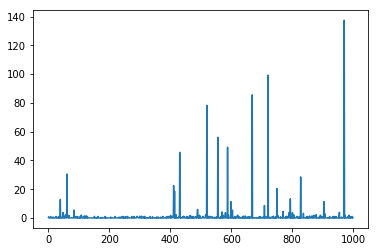

In [201]:
sorted_hist = sorted(hist, key=lambda x: x[0], reverse = False)
values = [elem[1] for elem in sorted_hist]
import matplotlib.pyplot as plt
plt.plot(values)

In [202]:
entropy(values)

tensor(5.5756)

In [234]:
#on test
%precision 2
# n, hist = targeted_diversity(learn, 150, 95)
# n, hist
n, hist = diversity(learn, 10, 95)
n, hist 

at batch no 0
at batch no 5
at batch no 10
at batch no 15
at batch no 20
at batch no 25
at batch no 30
at batch no 35
at batch no 40
at batch no 45
at batch no 50
at batch no 55
at batch no 60
at batch no 65
at batch no 70
at batch no 75
at batch no 80
at batch no 85
at batch no 90
at batch no 95
at batch no 100
at batch no 105
at batch no 110
at batch no 115
at batch no 120
at batch no 125
at batch no 130
at batch no 135
at batch no 140
at batch no 145
at batch no 150
at batch no 155
at batch no 160
at batch no 165
at batch no 170
at batch no 175
at batch no 180
at batch no 185
at batch no 190
at batch no 195
at batch no 200
at batch no 205
at batch no 210
at batch no 215
at batch no 220
at batch no 225
at batch no 230
at batch no 235
at batch no 240
at batch no 245
at batch no 250
at batch no 255
at batch no 260
at batch no 265
at batch no 270
at batch no 275
at batch no 280
at batch no 285
at batch no 290
at batch no 295
at batch no 300
at batch no 305
at batch no 310
at batch no 31

at batch no 2475
at batch no 2480
at batch no 2485
at batch no 2490
at batch no 2495
at batch no 2500
at batch no 2505
at batch no 2510
at batch no 2515
at batch no 2520
at batch no 2525
at batch no 2530
at batch no 2535
at batch no 2540
at batch no 2545
at batch no 2550
at batch no 2555
at batch no 2560
at batch no 2565
at batch no 2570
at batch no 2575
at batch no 2580
at batch no 2585
at batch no 2590
at batch no 2595
at batch no 2600
at batch no 2605
at batch no 2610
at batch no 2615
at batch no 2620
at batch no 2625
at batch no 2630
at batch no 2635
at batch no 2640
at batch no 2645
at batch no 2650
at batch no 2655
at batch no 2660
at batch no 2665
at batch no 2670
at batch no 2675
at batch no 2680
at batch no 2685
at batch no 2690
at batch no 2695
at batch no 2700
at batch no 2705
at batch no 2710
at batch no 2715
at batch no 2720
at batch no 2725
at batch no 2730
at batch no 2735
at batch no 2740
at batch no 2745
at batch no 2750
at batch no 2755
at batch no 2760
at batch no 27

(320,
 [(721, 14501.80),
  (669, 3372.80),
  (520, 3202.30),
  (750, 2116.30),
  (556, 2073.50),
  (414, 1936.70),
  (588, 1714.80),
  (431, 1556.00),
  (411, 1513.90),
  (61, 1296.50),
  (828, 1069.60),
  (39, 556.00),
  (904, 484.50),
  (709, 433.30),
  (794, 431.50),
  (971, 369.80),
  (489, 295.10),
  (614, 281.80),
  (790, 258.20),
  (599, 249.00),
  (893, 236.70),
  (581, 230.00),
  (955, 229.90),
  (490, 229.70),
  (770, 198.40),
  (509, 150.40),
  (84, 147.10),
  (401, 126.80),
  (419, 119.20),
  (48, 113.50),
  (60, 107.90),
  (56, 106.10),
  (741, 103.50),
  (516, 102.80),
  (67, 101.10),
  (748, 98.20),
  (646, 81.90),
  (824, 81.70),
  (837, 81.60),
  (762, 76.80),
  (703, 75.10),
  (46, 74.00),
  (580, 73.00),
  (412, 71.00),
  (582, 69.70),
  (151, 69.00),
  (907, 68.20),
  (621, 64.10),
  (737, 64.10),
  (464, 64.00),
  (791, 62.90),
  (973, 62.80),
  (55, 62.60),
  (406, 60.70),
  (591, 58.20),
  (636, 57.40),
  (319, 56.80),
  (455, 56.70),
  (805, 56.40),
  (800, 56.0

In [235]:
#on test
%precision 2
# n, hist = targeted_diversity(learn, 150, 95)
# n, hist
n, hist = diversity(learn, 10, 95)
n, hist 

at batch no 0
at batch no 5
at batch no 10
at batch no 15
at batch no 20
at batch no 25
at batch no 30
at batch no 35
at batch no 40
at batch no 45
at batch no 50
at batch no 55
at batch no 60
at batch no 65
at batch no 70
at batch no 75
at batch no 80
at batch no 85
at batch no 90
at batch no 95
at batch no 100
at batch no 105
at batch no 110
at batch no 115
at batch no 120
at batch no 125
at batch no 130
at batch no 135
at batch no 140
at batch no 145
at batch no 150
at batch no 155
at batch no 160
at batch no 165
at batch no 170
at batch no 175
at batch no 180
at batch no 185
at batch no 190
at batch no 195
at batch no 200
at batch no 205
at batch no 210
at batch no 215
at batch no 220
at batch no 225
at batch no 230
at batch no 235
at batch no 240
at batch no 245
at batch no 250
at batch no 255
at batch no 260
at batch no 265
at batch no 270
at batch no 275
at batch no 280
at batch no 285
at batch no 290
at batch no 295
at batch no 300
at batch no 305
at batch no 310
at batch no 31

at batch no 2475
at batch no 2480
at batch no 2485
at batch no 2490
at batch no 2495
at batch no 2500
at batch no 2505
at batch no 2510
at batch no 2515
at batch no 2520
at batch no 2525
at batch no 2530
at batch no 2535
at batch no 2540
at batch no 2545
at batch no 2550
at batch no 2555
at batch no 2560
at batch no 2565
at batch no 2570
at batch no 2575
at batch no 2580
at batch no 2585
at batch no 2590
at batch no 2595
at batch no 2600
at batch no 2605
at batch no 2610
at batch no 2615
at batch no 2620
at batch no 2625
at batch no 2630
at batch no 2635
at batch no 2640
at batch no 2645
at batch no 2650
at batch no 2655
at batch no 2660
at batch no 2665
at batch no 2670
at batch no 2675
at batch no 2680
at batch no 2685
at batch no 2690
at batch no 2695
at batch no 2700
at batch no 2705
at batch no 2710
at batch no 2715
at batch no 2720
at batch no 2725
at batch no 2730
at batch no 2735
at batch no 2740
at batch no 2745
at batch no 2750
at batch no 2755
at batch no 2760
at batch no 27

(357,
 [(721, 10334.30),
  (669, 3492.10),
  (971, 3086.20),
  (556, 2534.20),
  (414, 2156.00),
  (520, 2136.60),
  (588, 2111.90),
  (750, 2070.40),
  (431, 1500.50),
  (828, 1262.30),
  (61, 1207.60),
  (411, 994.40),
  (904, 655.90),
  (39, 618.20),
  (794, 582.00),
  (709, 373.80),
  (489, 363.20),
  (614, 348.80),
  (599, 327.60),
  (490, 258.50),
  (955, 252.50),
  (790, 240.20),
  (581, 238.20),
  (84, 218.80),
  (893, 218.60),
  (770, 209.30),
  (48, 143.20),
  (509, 141.90),
  (604, 139.40),
  (401, 122.10),
  (907, 113.60),
  (837, 111.10),
  (419, 110.80),
  (824, 109.50),
  (46, 95.70),
  (67, 95.00),
  (748, 94.90),
  (60, 93.80),
  (741, 93.10),
  (56, 86.30),
  (572, 83.30),
  (412, 82.00),
  (973, 79.90),
  (580, 78.20),
  (762, 78.10),
  (805, 78.00),
  (591, 76.30),
  (651, 75.80),
  (319, 72.00),
  (646, 71.90),
  (151, 70.90),
  (621, 69.30),
  (516, 69.00),
  (582, 68.40),
  (55, 67.70),
  (737, 66.90),
  (703, 65.80),
  (464, 63.20),
  (406, 62.40),
  (879, 62.20

In [236]:
#on test
%precision 2
# n, hist = targeted_diversity(learn, 150, 95)
# n, hist
n, hist = diversity(learn, 10, 95)
n, hist 

at batch no 0
at batch no 5
at batch no 10
at batch no 15
at batch no 20
at batch no 25
at batch no 30
at batch no 35
at batch no 40
at batch no 45
at batch no 50
at batch no 55
at batch no 60
at batch no 65
at batch no 70
at batch no 75
at batch no 80
at batch no 85
at batch no 90
at batch no 95
at batch no 100
at batch no 105
at batch no 110
at batch no 115
at batch no 120
at batch no 125
at batch no 130
at batch no 135
at batch no 140
at batch no 145
at batch no 150
at batch no 155
at batch no 160
at batch no 165
at batch no 170
at batch no 175
at batch no 180
at batch no 185
at batch no 190
at batch no 195
at batch no 200
at batch no 205
at batch no 210
at batch no 215
at batch no 220
at batch no 225
at batch no 230
at batch no 235
at batch no 240
at batch no 245
at batch no 250
at batch no 255
at batch no 260
at batch no 265
at batch no 270
at batch no 275
at batch no 280
at batch no 285
at batch no 290
at batch no 295
at batch no 300
at batch no 305
at batch no 310
at batch no 31

at batch no 2475
at batch no 2480
at batch no 2485
at batch no 2490
at batch no 2495
at batch no 2500
at batch no 2505
at batch no 2510
at batch no 2515
at batch no 2520
at batch no 2525
at batch no 2530
at batch no 2535
at batch no 2540
at batch no 2545
at batch no 2550
at batch no 2555
at batch no 2560
at batch no 2565
at batch no 2570
at batch no 2575
at batch no 2580
at batch no 2585
at batch no 2590
at batch no 2595
at batch no 2600
at batch no 2605
at batch no 2610
at batch no 2615
at batch no 2620
at batch no 2625
at batch no 2630
at batch no 2635
at batch no 2640
at batch no 2645
at batch no 2650
at batch no 2655
at batch no 2660
at batch no 2665
at batch no 2670
at batch no 2675
at batch no 2680
at batch no 2685
at batch no 2690
at batch no 2695
at batch no 2700
at batch no 2705
at batch no 2710
at batch no 2715
at batch no 2720
at batch no 2725
at batch no 2730
at batch no 2735
at batch no 2740
at batch no 2745
at batch no 2750
at batch no 2755
at batch no 2760
at batch no 27

(323,
 [(721, 10615.70),
  (520, 5087.20),
  (669, 3467.10),
  (971, 2482.60),
  (411, 2048.30),
  (414, 1855.90),
  (750, 1826.30),
  (556, 1802.90),
  (431, 1549.50),
  (61, 1295.20),
  (588, 1134.90),
  (828, 1087.60),
  (39, 547.10),
  (904, 507.60),
  (709, 430.10),
  (794, 388.20),
  (599, 331.70),
  (489, 314.10),
  (790, 286.00),
  (614, 260.70),
  (955, 238.90),
  (490, 230.90),
  (581, 230.00),
  (893, 216.60),
  (770, 186.50),
  (84, 167.90),
  (419, 164.90),
  (509, 147.10),
  (516, 146.30),
  (837, 132.50),
  (56, 122.30),
  (48, 121.80),
  (401, 119.20),
  (60, 107.50),
  (801, 104.90),
  (67, 103.30),
  (570, 103.30),
  (741, 96.20),
  (604, 86.50),
  (748, 86.40),
  (907, 82.20),
  (824, 82.10),
  (46, 76.30),
  (973, 74.50),
  (646, 74.40),
  (762, 74.00),
  (703, 73.00),
  (580, 72.40),
  (582, 68.70),
  (151, 68.00),
  (443, 67.30),
  (737, 66.60),
  (464, 64.60),
  (412, 63.80),
  (621, 63.60),
  (455, 63.30),
  (55, 62.70),
  (791, 61.80),
  (651, 61.20),
  (406, 6

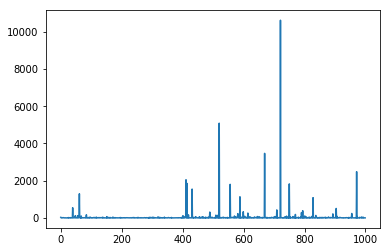

In [237]:
# on test
sorted_hist = sorted(hist, key=lambda x: x[0], reverse = False)
values = [elem[1] for elem in sorted_hist]
import matplotlib.pyplot as plt
plt.plot(values)

In [238]:
#on test
entropy(values)

tensor(5.6691)

In [ ]:
def make_triplet_samples(z, margin, r2, r3):
  positive_sample = z + random_vector_volume(z.shape, 0, margin).cuda() 
  negative_sample = z + random_vector_volume(z.shape, r2, r3).cuda()
  return positive_sample, negative_sample

def random_vector_surface(shape, r = 1.):
  mat = torch.randn(size=shape).cuda()
  norm = torch.norm(mat, p=2, dim=1, keepdim = True).cuda()
  return (mat/norm) * r

def random_vector_volume(shape, inner_r, outer_r):
  fraction = torch.empty(shape[0]).uniform_(inner_r, outer_r).cuda()
  fraction = ((fraction / outer_r) ** (1 / shape[1])) * outer_r # volume-normalize the fraction
  fraction.unsqueeze_(-1)
  return random_vector_surface(shape, 1) * fraction

In [ ]:
from collections import Counter

def most_frequent(x):
  return Counter(x).most_common(1)[0]

def preds_around(center, radius, n_preds, model, dummy_img):
  z_s = random_vector_volume([n_preds, 10], radius, radius + 0.01) + center[None]
  noises = model.forward_z(z_s)
  perturbed_imgs = noises + dummy_img 
  return torch.argmax(arch(perturbed_imgs), 1)
  
def most_freq_pred_around(center, radius, n_preds, model, dummy_img):
  preds = preds_around(center, radius, n_preds, model, dummy_img)
  most_freq = most_frequent(preds.tolist())
  return (class_index_to_label(most_freq[0]), most_freq[1]/n_preds)

def investigate_neighborhood(z, step, model, dummy_img):
  with torch.no_grad():
    result = []
    for radius in np.arange(0.1, 6., step):
#       print("creating {} more preds".format(int(10 + 5 * (radius ** 2))))
      most_freq_pred = most_freq_pred_around(z, radius, int(10 + 5 * (radius ** 2)), model, dummy_img)
      result.append((radius, most_freq_pred))
    return result

In [ ]:
#experiment 1

z = torch.tensor([0.5] * 10).cuda()
# z = torch.empty(10).uniform_(-1, 1).cuda()
# z_s = z[None]

model = learn.model.eval()
x_img = normalize(learn.data.train_ds[50][0].data.cuda())
  
for i in range(6):
  z = torch.empty(10).uniform_(-1, 1).cuda()
  print("investigation for: ", z)
  for elem in investigate_neighborhood(z, 0.5, model, x_img):
    print(elem)
print("done")

In [ ]:
#experiment 1-1: modified investigate_z
z_investigate_path = '/root/Derakhshani/adversarial/textual_notes/investigate_z_{}.txt'.format(env.save_filename)
if Path(z_investigate_path).exists(): raise FileExistsError("file already exists")
file = open(str(z_investigate_path), 'w')
        
for i, (z, noise) in enumerate(zip(pruned_z_s, pruned_noises)):
  hist = compute_prediction_histogram(learn, noise)
  indexed_hist = [(i, val) for i, val in enumerate(hist)]
  sorted_hist = sorted(indexed_hist, key=lambda x: x[1], reverse=True)
  labeled_hist = [(class_index_to_label(i), count) for i, count in sorted_hist]
  print("result {}:".format(i))
  print(big_vector_to_str(z))
  print(labeled_hist[:6])
  print("\n\n")
  
  file.write("result {}:\n".format(i))
  file.write(big_vector_to_str(z) + "\n")
  file.write(str(labeled_hist[:6]))
  file.write("\n\n\n")
  file.flush()

In [ ]:
#experiment 2
import itertools
z_s = [torch.tensor(t).cuda() for t in itertools.product( *([[-0.33, 0.33]] * 10) )]
model = learn.model.eval()
noises = []
with torch.no_grad():
  for z in z_s:
    noises.append(model.forward_single_z(z))

In [ ]:
x_img = normalize(learn.data.train_ds[50][0].data.cuda())

preds = []
for noise in noises:
  perturbed_img = x_img + noise
  preds.append(torch.argmax(arch(perturbed_img[None]), 1)[0].item())

from collections import Counter
result = [(class_index_to_label(index), count) for index, count in Counter(preds).most_common(5)]
result

In [ ]:
#experiment 3
import itertools
dimension_values = [[-0.9, 0.9]] * z_dim
for i in range(z_dim):
  if i % 100 != 0:
    dimension_values[i] = [0.]
# dimension_values[0] = [0.]
# dimension_values[3] = [0.]
# dimension_values[6] = [0.]
# dimension_values[9] = [0.]
pruned_z_s = [torch.tensor(t).cuda() for t in itertools.product(*dimension_values)]
model = learn.model.eval()
with torch.no_grad():
  pruned_noises = [model.forward_single_z(z) for z in pruned_z_s]

In [ ]:
#experiment 3: for the targeted-attack case
pruned_z_s = []
for i in range(z_dim):
  new_z = torch.zeros(z_dim).cuda()
  new_z[i] = 1.
  pruned_z_s.append(new_z)
  
model = learn.model.eval()
with torch.no_grad():
  pruned_noises = [model.forward_single_z(z) for z in pruned_z_s]

In [ ]:
#experiment 3-1: noises for 
pruned_z_s = []
# for i in range(z_dim):
#   new_z = torch.empty(z_dim).uniform_(0,1).cuda().detach()
#   pruned_z_s.append(new_z)

for i in range(z_dim):
  new_z = torch.zeros(z_dim).cuda().detach()
  new_z[i] = 1.
  pruned_z_s.append(new_z)
  
model = learn.model.eval()
with torch.no_grad():
  pruned_noises = [model.forward_single_z(z) for z in pruned_z_s]

In [ ]:
for noise in pruned_noises[0:200]:
  img = noise_to_image(noise)
  img.show()

In [ ]:
# spider web
z_values = [
  [ 0.33, -0.33,  0.33,  0.33, -0.33,  0.33, -0.33, -0.33, -0.33, -0.33],
  [ 0.33,  0.33, -0.33, -0.33, -0.33,  0.33, -0.33,  0.33, -0.33, -0.33],
  [ 0.33,  0.33, -0.33,  0.33,  0.33, -0.33, -0.33, -0.33,  0.33, -0.33],
  [-0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33, -0.33],
  [-0.33, -0.33, -0.33, -0.33, -0.33,  0.33,  0.33, -0.33,  0.33,  0.33],
  [-0.33, -0.33, -0.33,  0.33,  0.33, -0.33, -0.33, -0.33, -0.33, -0.33],
  [-0.33, -0.33,  0.33,  0.33, -0.33, -0.33,  0.33, -0.33,  0.33, -0.33],
  [-0.33,  0.33, -0.33,  0.33,  0.33, -0.33,  0.33,  0.33,  0.33,  0.33],
  [-0.33,  0.33,  0.33,  0.33, -0.33, -0.33,  0.33,  0.33, -0.33, -0.33],
  [ 0.33, -0.33, -0.33, -0.33,  0.33,  0.33, -0.33, -0.33, -0.33, -0.33],
  [ 0.33, -0.33,  0.33,  0.33, -0.33, -0.33,  0.33,  0.33, -0.33,  0.33],
  [ 0.33,  0.33, -0.33,  0.33, -0.33, -0.33,  0.33,  0.33, -0.33,  0.33],
  [ 0.33,  0.33,  0.33, -0.33, -0.33, -0.33, -0.33,  0.33, -0.33, -0.33],
  [ 0.33,  0.33,  0.33,  0.33, -0.33, -0.33, -0.33,  0.33, -0.33, -0.33],
  [ 0.33,  0.33,  0.33,  0.33,  0.33,  0.33,  0.33,  0.33,  0.33, -0.33],
  [ 0.33,  0.33,  0.33, -0.33, -0.33, -0.33, -0.33,  0.33,  0.33, -0.33],
]

if any(z_values.count(x) > 1 for x in z_values):
  raise Exception("duplicate")
  
z_s = [torch.tensor(z).cuda() for z in z_values]
model = learn.model.eval()

for z in z_s:
  img = noise_to_image(model.forward_single_z(z))
  img.show()


In [ ]:
z_values = [
  # window screen
  [-0.33,  0.33,  0.33, -0.33, -0.33,  0.33, -0.33, -0.33, -0.33, -0.33],
  [-0.33,  0.33,  0.33, -0.33, -0.33, -0.33, -0.33, -0.33,  0.33,  0.33],
]

if any(z_values.count(x) > 1 for x in z_values):
  raise Exception("duplicate")
  
z_s = [torch.tensor(z).cuda() for z in z_values]
model = learn.model.eval()

for z in z_s:
  img = noise_to_image(model.forward_single_z(z))
  img.show()

In [ ]:
#vgg-16_12 most repeated labels:
l = [(611, 215.0),
  (474, 194.1),
  (398, 120.3),
  (721, 79.6),
  (741, 73.5),
  (510, 62.5)]

[(class_index_to_label(index), count) for index, count in l]

In [ ]:
# learn.recorder.plot_losses()
# learn.recorder.plot_lr()
# learn.recorder.plot_metrics()

In [ ]:
fooling_rates = []
model = learn.model.eval()
learn.metrics = [validation_single_perturbation]
for i in range(10):
  global_perturbations = model(torch.rand(1, 3, 224, 244).cuda())[0]
  nag_util.global_perturbations = global_perturbations
  fooling_rates.append(learn.validate()[1].cpu().item())
  print("%d : %f"%(i, fooling_rates[-1]))

mean = np.mean(fooling_rates)
stddev = np.std(fooling_rates)
print(mean, stddev); print(fooling_rates)

In [ ]:
#the Image works good for floats in range [0..1]
model = learn.model.eval()

x_img = learn.data.train_ds[200][0]
x = normalize(x_img.data.cuda())
z = torch.tensor([-0.33,  0.33, -0.33, -0.33, -0.33,  0.33,  0.33, -0.33, -0.33, -0.33], dtype=torch.float32).cuda()
# z = torch.empty(z_dim).uniform_(-1,1).cuda()
p = model.forward_single_z(z).detach()

p_x = x + p
# print("img range, noise range")
# print_range(x); print_range(p)
adv_label = class_index_to_label(arch(p_x[None]).argmax(1).item())
print_big_vector(arch(p_x[None])[0])
p_x = denormalize(p_x)
p_x.clamp_(0,1)


#prepare images
p_x_img = Image(p_x)
p = scale_to_range(p, [0., 1.])
p_img = Image(p)
x_img.show()
p_img.show()
p_x_img.show()


# print_range(p)
# print_range(denormalize(x))
# print_range(p_x)

benign_label = class_index_to_label(arch(x[None]).argmax(1).item())

print_big_vector(arch(x[None])[0])
print(benign_label, adv_label)

In [ ]:
z1 = torch.tensor([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=torch.float32).cuda()
p1 = model.forward_single_z(z1)

z2 = torch.tensor([1, -1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=torch.float32).cuda()
p2 = model.forward_single_z(z2)

z3 = torch.tensor([1, 1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=torch.float32).cuda()
p3 = model.forward_single_z(z3)

l2_distance(p1, p3)

In [ ]:
#the Image works good for floats in range [0..1]
model = learn.model.eval()

x_img = learn.data.train_ds[4][0]
x = x_img.data[None].cuda()
p = model(x)[0].squeeze().detach() 
x = x.squeeze()
x = normalize(x)

p_x = x + p
p_x = denormalize(p_x)
p_x.clamp_(0,1)


#prepare images
p_x_img = Image(p_x)
p = scale_to_range(p, [0.,1.])
p_img = Image(p)
# x_img.show()
p_img.show()
# p_x_img.show()

print_range(p)
print_range(x)
print_range(p_x)